# AI Trading Strategy Comparison using VectorBT

## 1. Environment & Imports

In [1]:
# === Essential Imports ===
import pandas as pd
import vectorbt as vbt
import matplotlib.pyplot as plt


## 2. Load Model Predictions
### 2.1 Load CSVs

In [2]:
# Reload CSVs normally
df_lstm = pd.read_csv('df_lstm.csv')
df_gru = pd.read_csv('df_gru.csv')
df_cnn = pd.read_csv('df_cnn.csv')
df_att = pd.read_csv('df_att.csv')
df_trans = pd.read_csv('df_trans.csv')


In [3]:
# === Load SPY Benchmark ===
df_spy = pd.read_csv("GSPC_fixed.csv")

# Preview the structure
print(df_spy.columns)
print(df_spy.head())


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adjusted_close', 'Volume'], dtype='object')
         Date       Open     High        Low    Close  Adjusted_close  \
0  2014-01-06  1832.3101  1837.16  1823.7300  1826.77         1826.77   
1  2014-01-07  1828.7100  1840.10  1828.7100  1837.88         1837.88   
2  2014-01-08  1837.9000  1840.02  1831.4000  1837.49         1837.49   
3  2014-01-09  1839.0000  1843.23  1830.3800  1838.13         1838.13   
4  2014-01-10  1840.0601  1843.15  1832.4301  1842.37         1842.37   

       Volume  
0  3294850000  
1  3511750000  
2  3652140000  
3  3581150000  
4  3335710000  


In [4]:
# === Format SPY Benchmark Data ===
df_spy['Date'] = pd.to_datetime(df_spy['Date'])
df_spy.set_index('Date', inplace=True)
df_spy = df_spy[['Adjusted_close']].rename(columns={'Adjusted_close': 'SPY'})

# Filter to match model time range
df_spy = df_spy.loc['2018-12-28':]

# Confirm
print(df_spy.head())
print(df_spy.index.min(), "to", df_spy.index.max())


                  SPY
Date                 
2018-12-28  2485.7400
2018-12-31  2506.8501
2019-01-02  2510.0300
2019-01-03  2447.8899
2019-01-04  2531.9399
2018-12-28 00:00:00 to 2025-03-07 00:00:00


### 2.2 Apply Synthetic Datetime Index

In [5]:
# === Step 1: Create synthetic datetime index and assign it ===
date_index = pd.date_range(start='2018-12-28', periods=len(df_lstm), freq='B')  # 'B' = business days

# Apply to all model DataFrames
for df in [df_lstm, df_gru, df_cnn, df_att, df_trans]:
    df['date'] = date_index
    df.set_index('date', inplace=True)


## 3. Signal Generation and Strategy Backtesting
- Simulate strategy execution using vectorbt

In [6]:
# === Step 2: Prepare Signals and Portfolios ===

# Helper to convert predictions to binary long-only signals
def generate_signals(df):
    return df['predictions'] > 0.5

# Dictionary of all models
model_dfs = {
    'LSTM': df_lstm.copy(),
    'GRU': df_gru.copy(),
    'CNN-LSTM': df_cnn.copy(),
    'ATT-LSTM': df_att.copy(),
    'Transformer': df_trans.copy()
}

# Prepare portfolios
portfolios = {}

for name, df in model_dfs.items():
    df['signal'] = generate_signals(df).astype(int)
    portfolios[name] = vbt.Portfolio.from_signals(
        close=df['log_returns'].add(1).cumprod(),  # synthetic price series from log returns
        entries=df['signal'] == 1,
        exits=df['signal'] == 0,
        freq='1D',
        init_cash=100,
        fees=0.001  # Optional: trading cost of 0.1%
    )


## 4. Performance Evaluation
### 4.1 Cumulative Returns

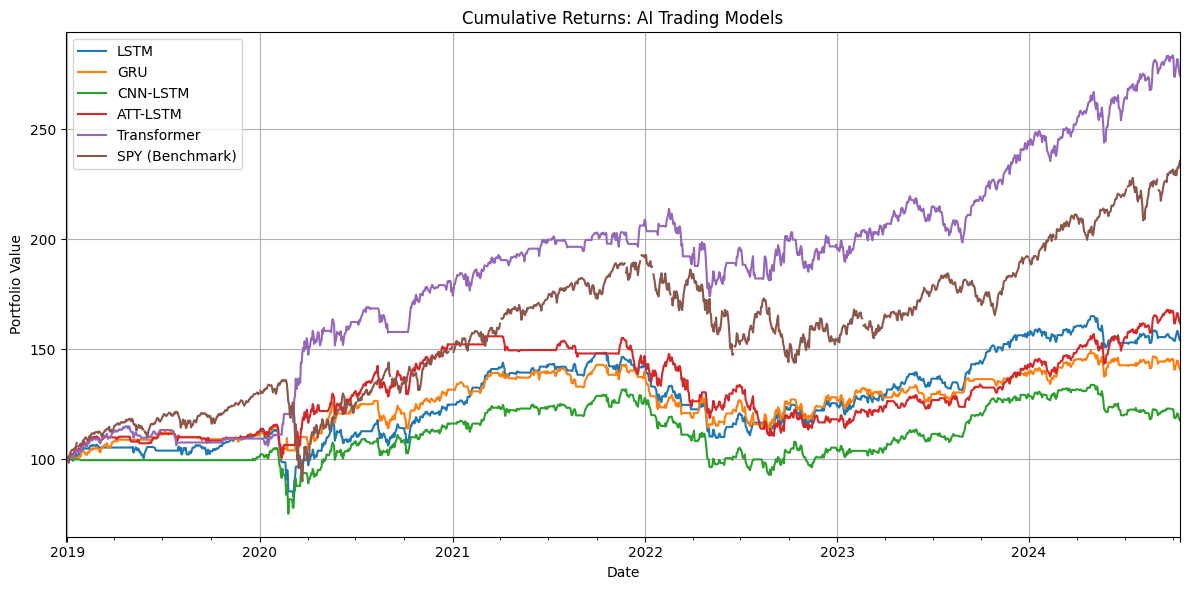

In [7]:
# === Step 3A: Plot Cumulative Returns ===

# Extract and compile cumulative portfolio values
cumulative_returns = pd.DataFrame({
    name: pf.value() for name, pf in portfolios.items()
})

# Normalize SPY to start at 100
spy_normalized = df_spy['SPY'] / df_spy['SPY'].iloc[0] * 100
cumulative_returns['SPY (Benchmark)'] = spy_normalized

# Plot using matplotlib
cumulative_returns.plot(title='Cumulative Returns: AI Trading Models', figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("cumulative_returns.png", dpi=150, bbox_inches='tight')
plt.show()


### 4.2 Performance Metrics

In [8]:
# === Step 3B: Extract Performance Metrics ===

# Helper to compile portfolio stats
performance_stats = pd.DataFrame()

for name, pf in portfolios.items():
    stats = {
        'Final Value': pf.value()[-1],
        'Total Return [%]': pf.total_return() * 100,
        'Annual Return [%]': pf.annualized_return() * 100,
        'Volatility [%]': pf.annualized_volatility() * 100,
        'Sharpe Ratio': pf.sharpe_ratio(),
        'Max Drawdown [%]': pf.max_drawdown() * 100,
    }
    performance_stats[name] = pd.Series(stats)

# === Add SPY Performance Metrics ===

spy_returns = df_spy['SPY'].pct_change().dropna()
spy_cum = (1 + spy_returns).cumprod() * 100

spy_stats = {
    'Final Value': spy_cum.iloc[-1],
    'Total Return [%]': (spy_cum.iloc[-1] / spy_cum.iloc[0] - 1) * 100,
    'Annual Return [%]': (1 + spy_returns.mean())**252 - 1,
    'Volatility [%]': spy_returns.std() * (252 ** 0.5) * 100,
    'Sharpe Ratio': (spy_returns.mean() / spy_returns.std()) * (252 ** 0.5),
    'Max Drawdown [%]': ((spy_cum / spy_cum.cummax()) - 1).min() * 100
}

performance_stats['SPY (Benchmark)'] = pd.Series(spy_stats)
    

# Transpose for better layout
performance_stats = performance_stats.T.round(2)

# Display sorted by Sharpe Ratio
performance_stats.sort_values(by='Sharpe Ratio', ascending=False)


,Final Value,Total Return [%],Annual Return [%],Volatility [%],Sharpe Ratio,Max Drawdown [%]
Transformer,274.54,174.54,27.61,18.24,1.43,-18.61
SPY (Benchmark),232.13,130.18,0.17,19.99,0.78,-33.92
ATT-LSTM,162.12,62.12,12.37,18.60,0.72,-29.09
LSTM,154.19,54.19,11.02,18.56,0.66,-27.05
GRU,140.97,40.97,8.64,16.47,0.59,-20.53
CNN-LSTM,117.70,17.70,4.01,19.54,0.30,-29.52


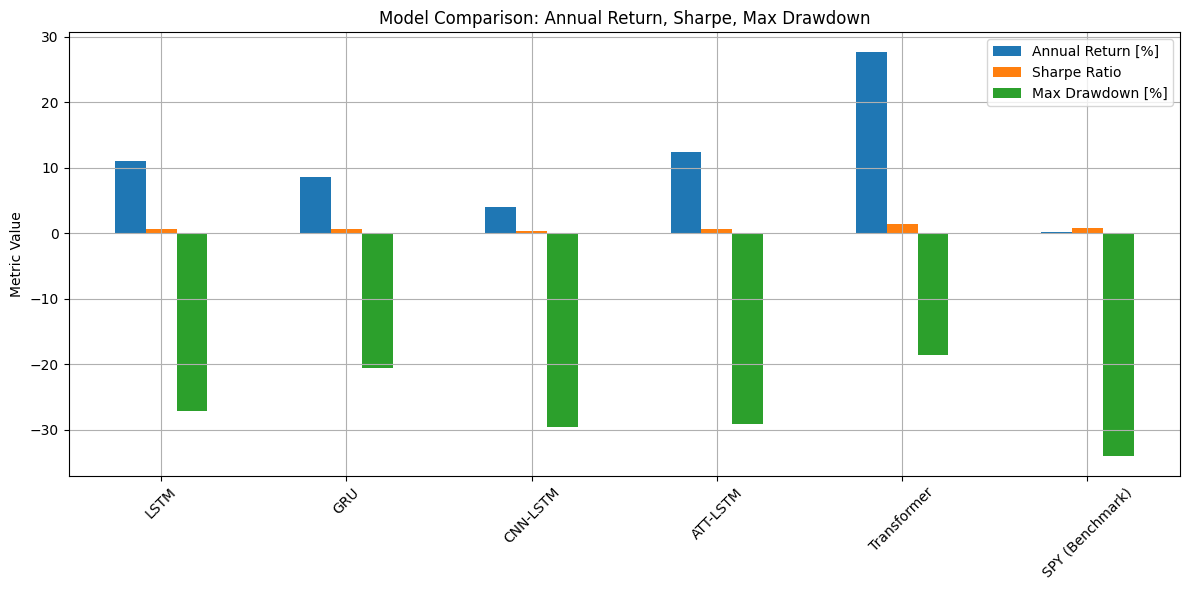

In [9]:
# === Step 3C: Visualize Key Metrics ===

# Choose metrics to visualize
metrics_to_plot = ['Annual Return [%]', 'Sharpe Ratio', 'Max Drawdown [%]']

# Plot each as a bar chart
performance_stats[metrics_to_plot].plot(
    kind='bar',
    figsize=(12, 6),
    title='Model Comparison: Annual Return, Sharpe, Max Drawdown'
)
plt.grid(True)
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("metrics_bar_plot.png", dpi=150, bbox_inches='tight')
plt.show()


### 4.3 Rolling Sharpe Ratio Analysis
- Evaluate 3-month rolling Sharpe to assess consistency

In [10]:
# === Step 3D: Compute Rolling Sharpe Ratios ===

rolling_sharpes = pd.DataFrame()

for name, pf in portfolios.items():
    rolling = pf.returns().rolling(window=63).mean() / pf.returns().rolling(window=63).std()
    rolling_sharpes[name] = rolling


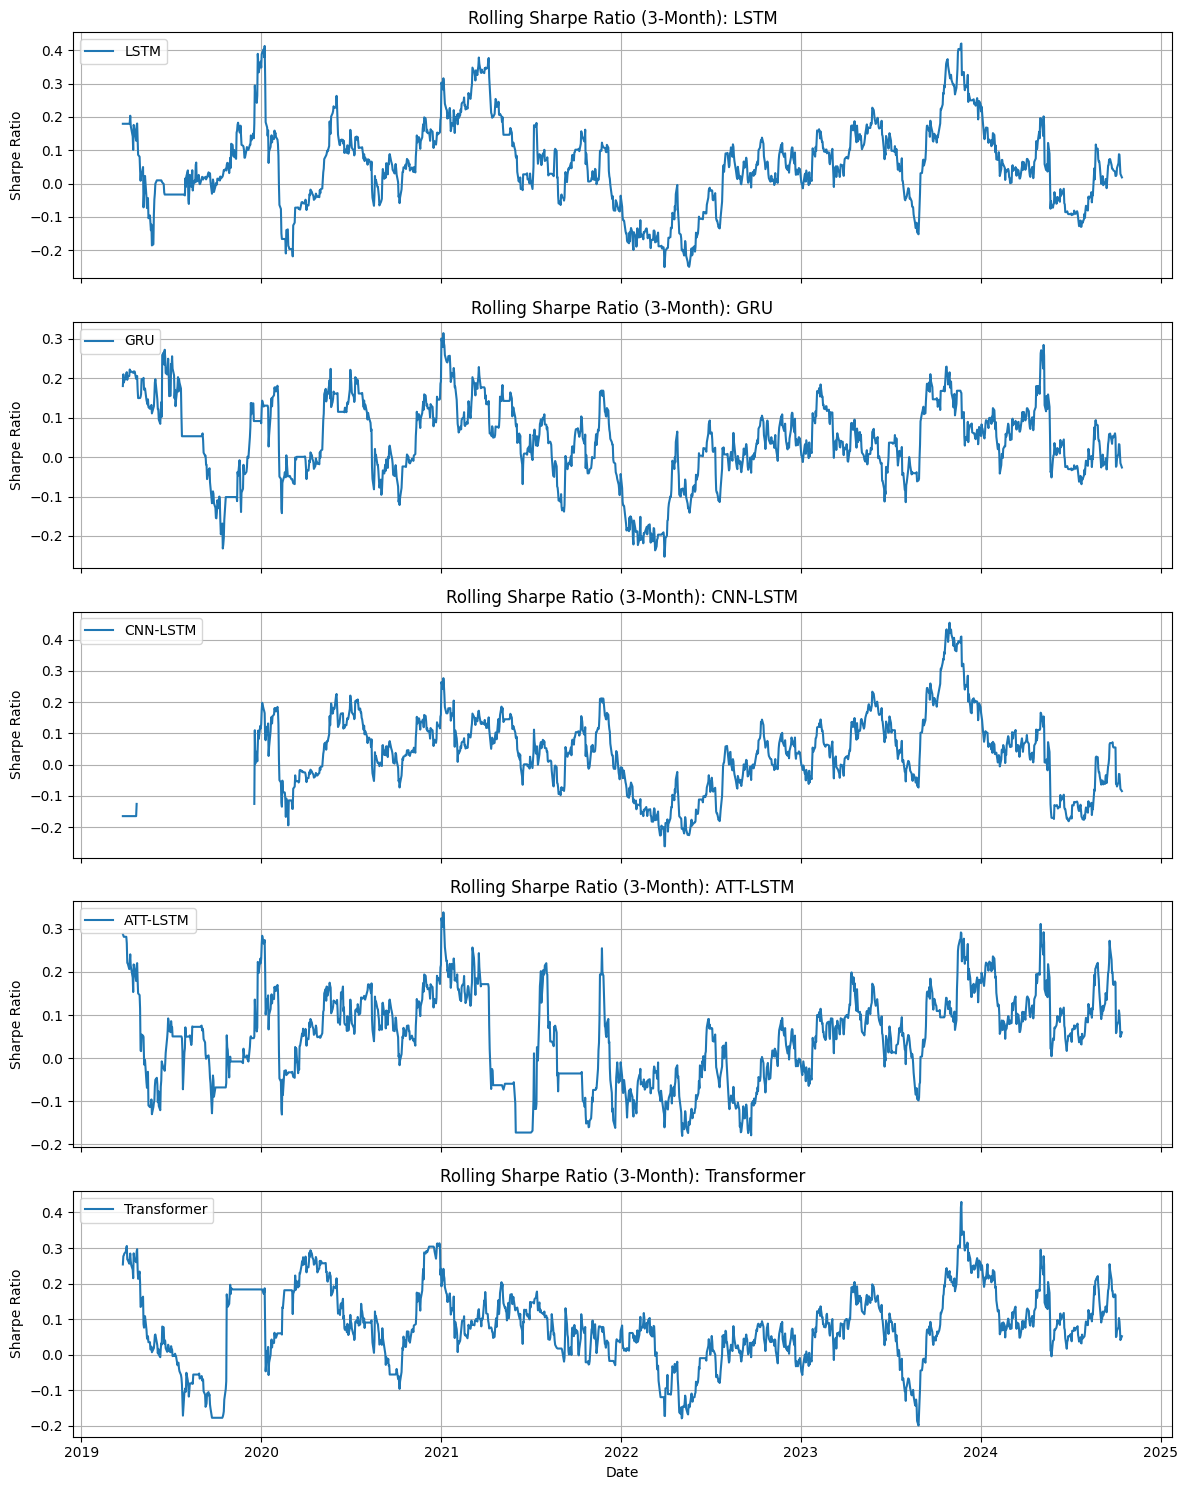

In [11]:
# === Step 3D (Alt): Multi-Panel Rolling Sharpe Plot ===

fig, axs = plt.subplots(nrows=len(rolling_sharpes.columns), ncols=1, figsize=(12, 3 * len(rolling_sharpes.columns)), sharex=True)

for i, col in enumerate(rolling_sharpes.columns):
    axs[i].plot(rolling_sharpes.index, rolling_sharpes[col], label=col)
    axs[i].set_title(f'Rolling Sharpe Ratio (3-Month): {col}', fontsize=12)
    axs[i].set_ylabel('Sharpe Ratio')
    axs[i].grid(True)
    axs[i].legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.savefig("rolling_sharpe_all_models.png", dpi=150, bbox_inches='tight')
plt.show()



## 5. Strategy Behavior Diagnostics
### 5.1 Transaction Cost Sensitivity

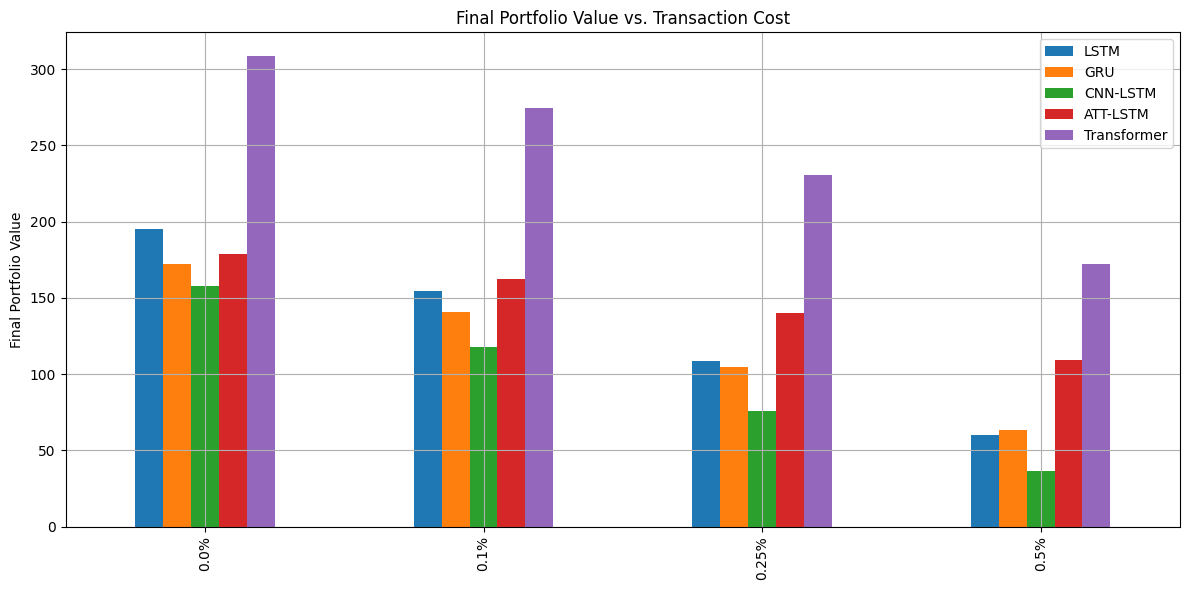

In [12]:
# === Step 4A: Transaction Cost Sensitivity Analysis ===

fee_levels = [0.0, 0.001, 0.0025, 0.005]  # 0%, 0.1%, 0.25%, 0.5%
fee_results = {}

for fee in fee_levels:
    temp_results = {}
    for name, df in model_dfs.items():
        df['signal'] = generate_signals(df).astype(int)
        pf = vbt.Portfolio.from_signals(
            close=df['log_returns'].add(1).cumprod(),
            entries=df['signal'] == 1,
            exits=df['signal'] == 0,
            freq='1D',
            init_cash=100,
            fees=fee
        )
        temp_results[name] = pf.value().iloc[-1]  # final portfolio value
    fee_results[f"{int(fee*10000)/100}%"] = temp_results

# Create DataFrame to visualize
fee_df = pd.DataFrame(fee_results).T
fee_df.plot(kind='bar', figsize=(12, 6), title='Final Portfolio Value vs. Transaction Cost')
plt.ylabel("Final Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("transaction_cost_sensitivity.png", dpi=300, bbox_inches='tight')
plt.show()
plt.show()


### 5.2 Turnover & Signal Activity

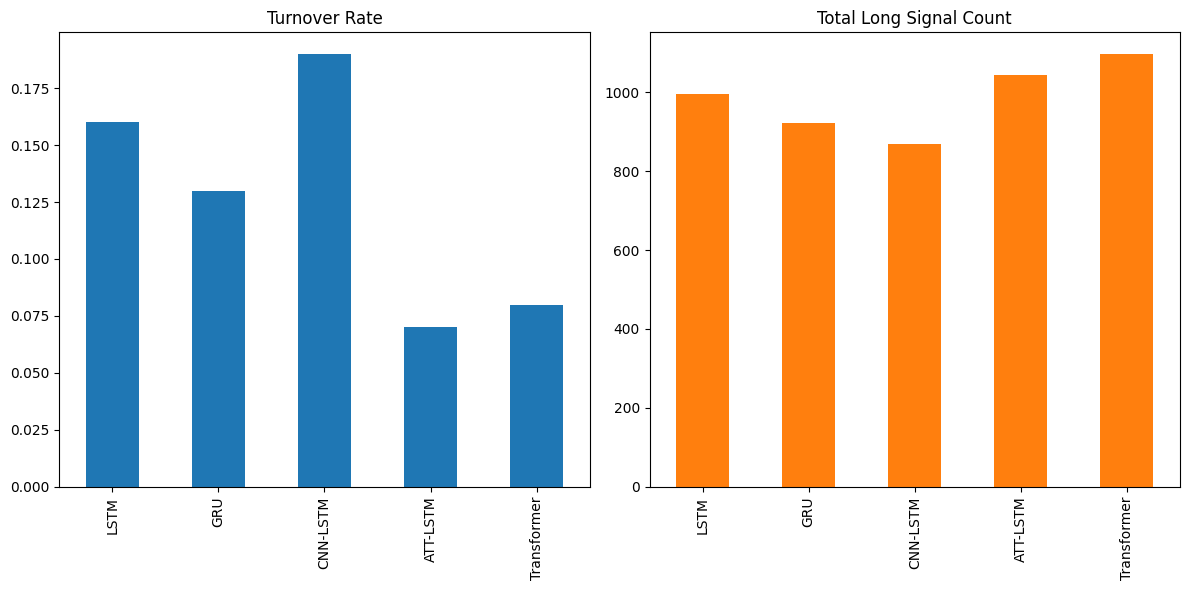

In [13]:
# === Step 4B: Turnover and Signal Activity ===

turnover_stats = {}

for name, df in model_dfs.items():
    df['signal'] = generate_signals(df).astype(int)
    signal_changes = df['signal'].diff().abs()
    turnover = signal_changes.sum() / len(df)  # turnover rate
    signal_count = df['signal'].sum()          # total long entries

    turnover_stats[name] = {
        'Turnover Rate': turnover,
        'Long Signal Count': signal_count
    }

turnover_df = pd.DataFrame(turnover_stats).T.round(2)

# Plot
turnover_df.plot(kind='bar', subplots=True, figsize=(12, 6),
                 title=['Turnover Rate', 'Total Long Signal Count'], layout=(1, 2), legend=False)
plt.tight_layout()
plt.savefig("signal_activity_count.png", dpi=150, bbox_inches='tight')
plt.show()


### 6. Cross-Model Strategy Correlation
- Correlation of trading signals and returns

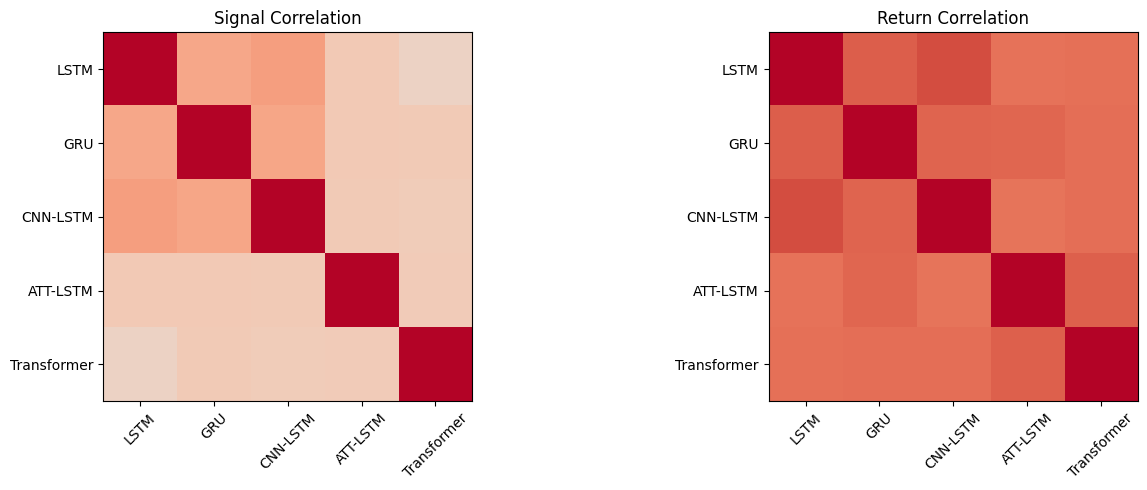

In [14]:
# === Step 4C: Correlation Between Strategies ===

# Extract signals and returns
signal_df = pd.DataFrame({name: df['signal'] for name, df in model_dfs.items()})
returns_df = pd.DataFrame({name: pf.returns() for name, pf in portfolios.items()})

# Compute correlations
signal_corr = signal_df.corr()
returns_corr = returns_df.corr()

# Plot heatmaps
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].imshow(signal_corr, cmap='coolwarm', vmin=-1, vmax=1)
axs[0].set_xticks(range(len(signal_corr.columns)))
axs[0].set_yticks(range(len(signal_corr.columns)))
axs[0].set_xticklabels(signal_corr.columns, rotation=45)
axs[0].set_yticklabels(signal_corr.columns)
axs[0].set_title("Signal Correlation")

axs[1].imshow(returns_corr, cmap='coolwarm', vmin=-1, vmax=1)
axs[1].set_xticks(range(len(returns_corr.columns)))
axs[1].set_yticks(range(len(returns_corr.columns)))
axs[1].set_xticklabels(returns_corr.columns, rotation=45)
axs[1].set_yticklabels(returns_corr.columns)
axs[1].set_title("Return Correlation")

plt.tight_layout()
plt.savefig("correlation_heatmaps.png", dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# === Step 4: Export Final Performance Stats ===
performance_stats.to_csv('model_comparison_summary.csv')


In [16]:
# If you want to include rolling sharpes too:
rolling_sharpes.to_csv('rolling_sharpes.csv')


## 7. Summary and Forward Directions
### Model Selection Rationale

This notebook presents a systematic comparison of five deep learning architectures for long-only trading strategies applied to SPY log returns:

- LSTM,

- GRU,

- CNN-LSTM,

- Attention-LSTM, and

- Transformer.

All models were evaluated based on key performance metrics such as annual return, Sharpe ratio, and maximum drawdown, as well as turnover, signal frequency, and robustness under varying transaction costs.

Notably, the Transformer model consistently outperformed others across all risk-adjusted return metrics, with the highest Sharpe Ratio, lowest drawdown, and strong performance stability under transaction cost stress tests.

In contrast, models like CNN-LSTM and GRU showed weaker Sharpe ratios and higher turnover, suggesting more fragile or overactive decision boundaries.

- Model selection was based not only on raw performance but also on:

- Risk-adjusted returns

- Execution efficiency (turnover, transaction cost resilience)

- Signal diversity (correlation diagnostics)

- Stability over time (rolling Sharpe analysis)

### Next Steps: Forward-Looking Enhancements

The analysis provides a strong foundation for more advanced development. Recommended next steps include:

1. **Model Ensembling (Forward Thinking):**
Explore ensembling strategies (e.g., majority vote, weighted ensemble, stacking) across architectures to:

- Improve signal stability

- Reduce overfitting

- Exploit model complementarities (as seen in low signal correlation)

2. **Live Simulation or Walk-Forward Analysis:**
Integrate walk-forward testing to capture model adaptability in shifting regimes.

4. **Feature Expansion or Multivariate Inputs:**
Introduce volatility/volume regimes, macro factors, or alternative data as inputs.

5. **Portfolio Allocation Extension:**
Move from binary signals to risk-aware allocation (e.g., volatility scaling or regime switching).

6. **Deploy with VectorBT Pro / Live Backtesting Tools:**
Extend to live environments with advanced vectorbt modules or integrate with broker APIs.